<a href="https://colab.research.google.com/github/hanhanwu/Hanhan_COLAB_Experiemnts/blob/master/optuna_quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Quick Introduction to Optuna

This Jupyter notebook goes through the basic usage of Optuna.

- Install Optuna
- Write a training algorithm that involves hyperparameters
  - Read train/valid data
  - Define and train model
  - Evaluate model
- Use Optuna to tune the hyperparameters (hyperparameter optimization, HPO)
- Visualize HPO

## Install `optuna`

Optuna can be installed via `pip` or `conda`.

In [ ]:
!pip install --quiet optuna

     |████████████████████████████████| 266kB 2.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 9.0MB/s 
     |████████████████████████████████| 163kB 54.3MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 112kB 54.0MB/s 
     |████████████████████████████████| 143kB 45.6MB/s 
     |████████████████████████████████| 81kB 8.8MB/s 


In [ ]:
import optuna

optuna.__version__

'2.3.0'

## Optimize Hyperparameters

### Define a simple scikit-learn model

We start with a simple random forest model to classify flowers in the Iris dataset. We define a function called `objective` that encapsulates the whole training process and outputs the accuracy of the model.

In [2]:
import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection
from IPython.display import Image

In [ ]:
def objective():
    iris = sklearn.datasets.load_iris()  # Prepare the data.
    
    clf = sklearn.ensemble.RandomForestClassifier(    
        n_estimators=5, max_depth=3)  # Define the model.
    
    return sklearn.model_selection.cross_val_score(
        clf, iris.data, iris.target, n_jobs=-1, cv=3).mean()  # Train and evaluate the model.

print('Accuracy: {}'.format(objective()))

### Optimize hyperparameters of the model

The hyperparameters of the above algorithm are `n_estimators` and `max_depth` for which we can try different values to see if the model accuracy can be improved. The `objective` function is modified to accept a trial object. This trial has several methods for sampling hyperparameters. We create a study to run the hyperparameter optimization and finally read the best hyperparameters.

In [ ]:
import optuna

def objective(trial):
    iris = sklearn.datasets.load_iris()
    
    n_estimators = trial.suggest_int('n_estimators', 2, 20)
    max_depth = int(trial.suggest_float('max_depth', 1, 32, log=True))
    
    clf = sklearn.ensemble.RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth)
    
    return sklearn.model_selection.cross_val_score(
        clf, iris.data, iris.target, n_jobs=-1, cv=3).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

It is possible to condition hyperparameters using Python `if` statements. We can for instance include another classifier, a support vector machine, in our HPO and define hyperparameters specific to the random forest model and the support vector machine.

In [ ]:
import sklearn.svm

def objective(trial):
    iris = sklearn.datasets.load_iris()

    classifier = trial.suggest_categorical('classifier', ['RandomForest', 'SVC'])
    
    if classifier == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 2, 20)
        max_depth = int(trial.suggest_float('max_depth', 1, 32, log=True))

        clf = sklearn.ensemble.RandomForestClassifier(
            n_estimators=n_estimators, max_depth=max_depth)
    else:
        c = trial.suggest_float('svc_c', 1e-10, 1e10, log=True)
        
        clf = sklearn.svm.SVC(C=c, gamma='auto')

    return sklearn.model_selection.cross_val_score(
        clf, iris.data, iris.target, n_jobs=-1, cv=3).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2020-11-07 20:01:17,585] A new study created in memory with name: no-name-21e9d677-f88a-4938-b681-8a0199eac851
[I 2020-11-07 20:01:18,681] Trial 0 finished with value: 0.9533333333333333 and parameters: {'classifier': 'RandomForest', 'n_estimators': 13, 'max_depth': 3.8568867328591665}. Best is trial 0 with value: 0.9533333333333333.
[I 2020-11-07 20:01:18,750] Trial 1 finished with value: 0.9666666666666667 and parameters: {'classifier': 'RandomForest', 'n_estimators': 15, 'max_depth': 3.0118134007693236}. Best is trial 1 with value: 0.9666666666666667.
[I 2020-11-07 20:01:18,828] Trial 2 finished with value: 0.9666666666666667 and parameters: {'classifier': 'RandomForest', 'n_estimators': 19, 'max_depth': 8.127633068621309}. Best is trial 1 with value: 0.9666666666666667.
[I 2020-11-07 20:01:18,916] Trial 3 finished with value: 0.9466666666666667 and parameters: {'classifier': 'RandomForest', 'n_estimators': 20, 'max_depth': 1.1911132650185514}. Best is trial 1 with value: 0.96666

Accuracy: 0.9733333333333333
Best hyperparameters: {'classifier': 'RandomForest', 'n_estimators': 15, 'max_depth': 3.9828763240550744}


### Plotting the study

Plotting the optimization history of the study.

In [ ]:
optuna.visualization.plot_optimization_history(study)

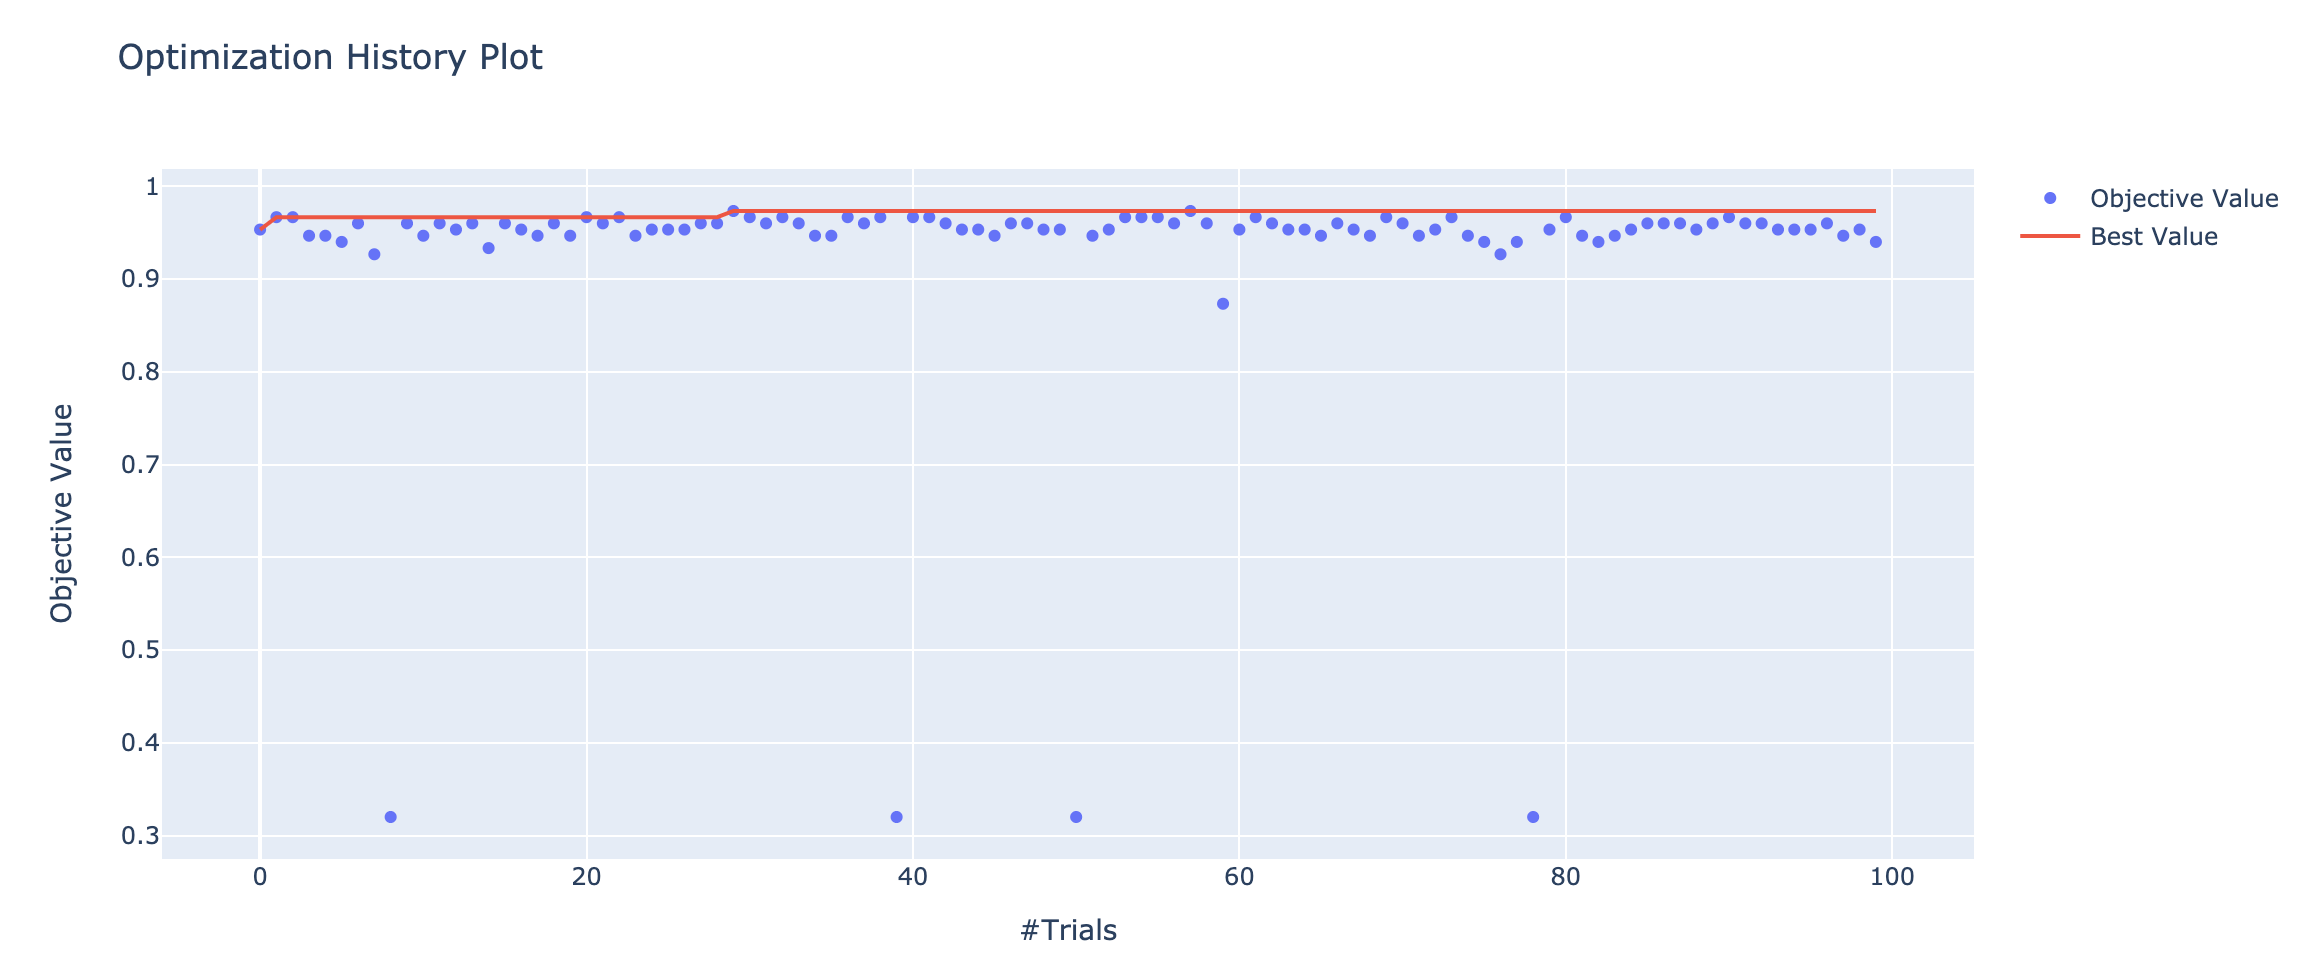

In [8]:
path="img3.png"
Image(path, width=800, height=400)

Plotting the accuracies for each hyperparameter for each trial.

In [ ]:
optuna.visualization.plot_slice(study)

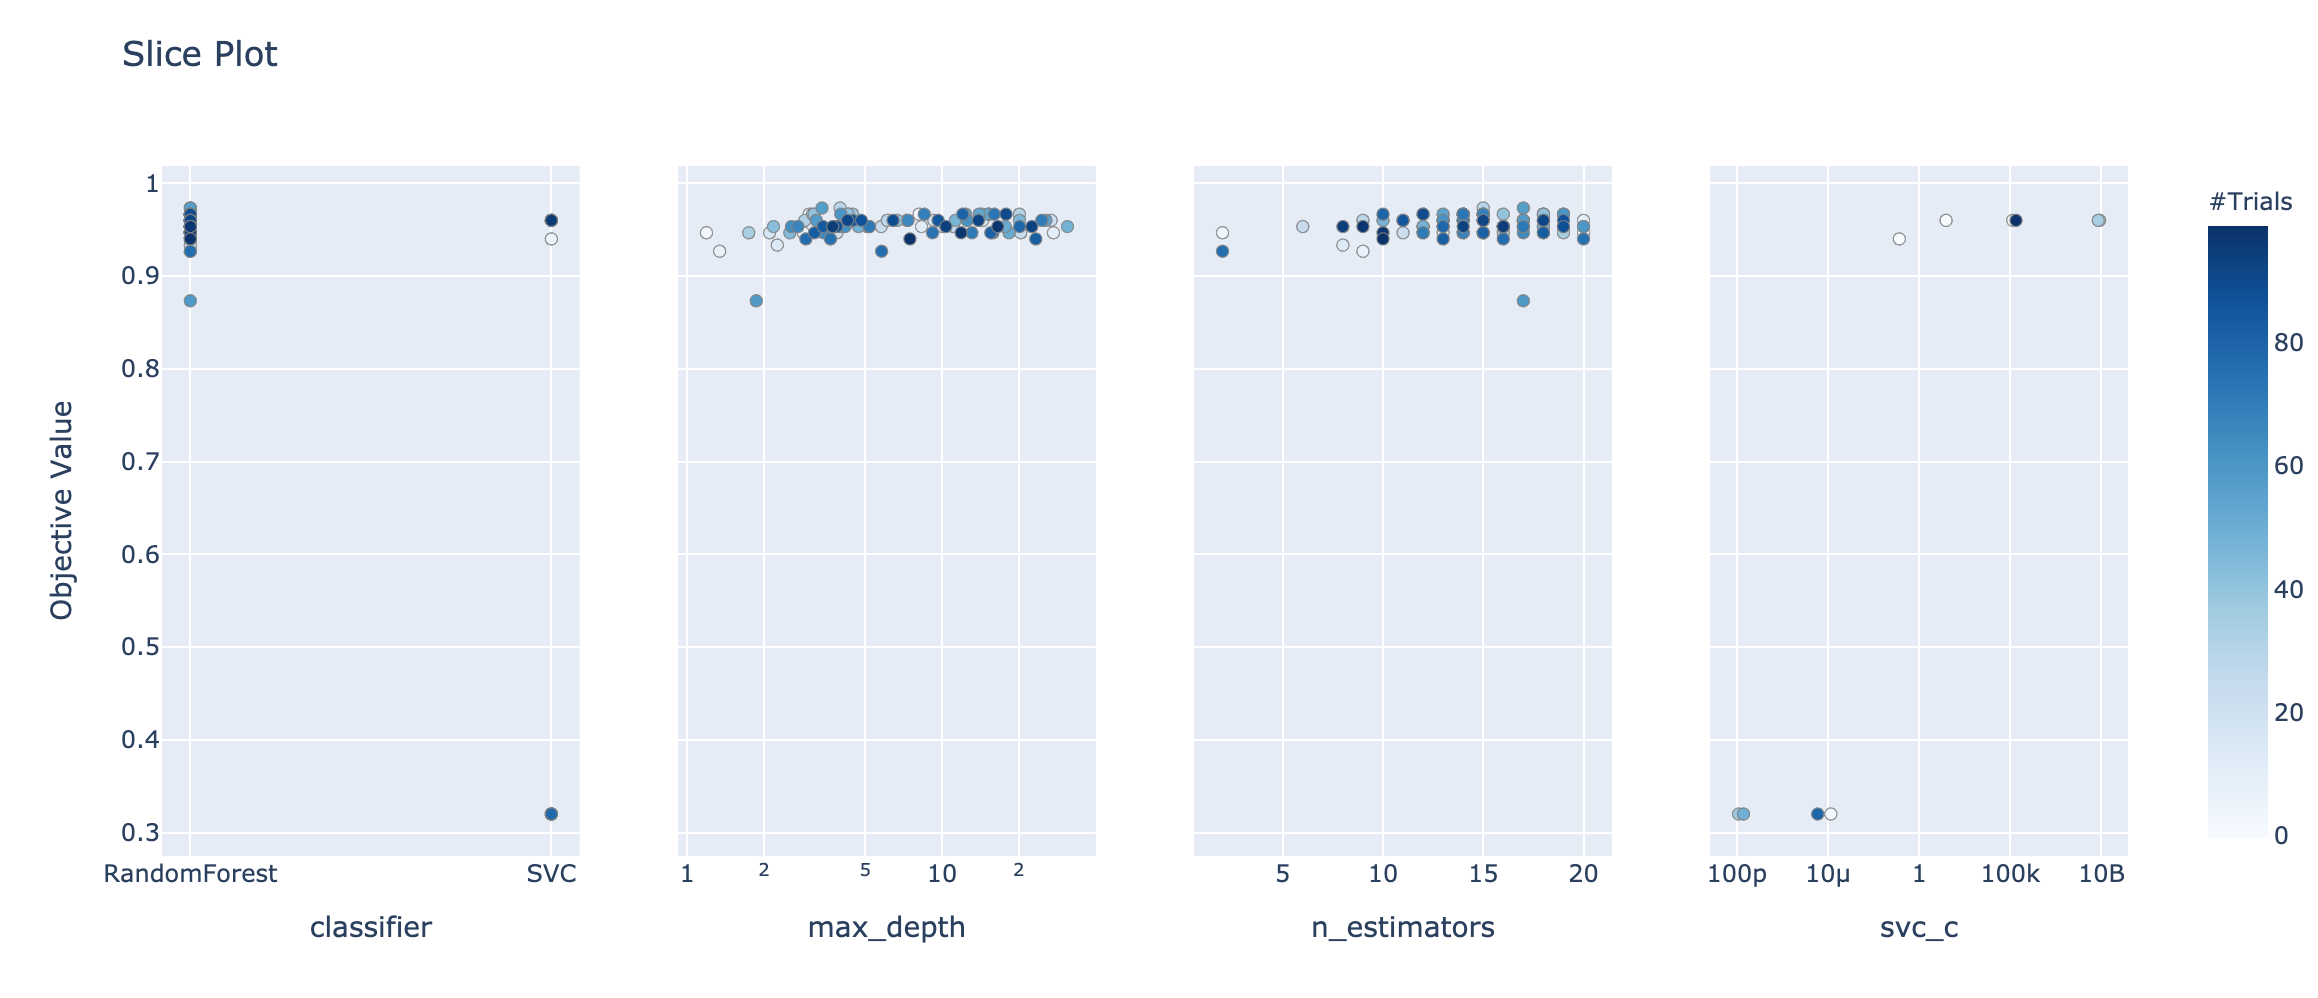

In [9]:
path="img2.png"
Image(path, width=800, height=400)

Plotting the accuracy surface for the hyperparameters involved in the random forest model.

In [ ]:
optuna.visualization.plot_contour(study, params=['n_estimators', 'max_depth'])

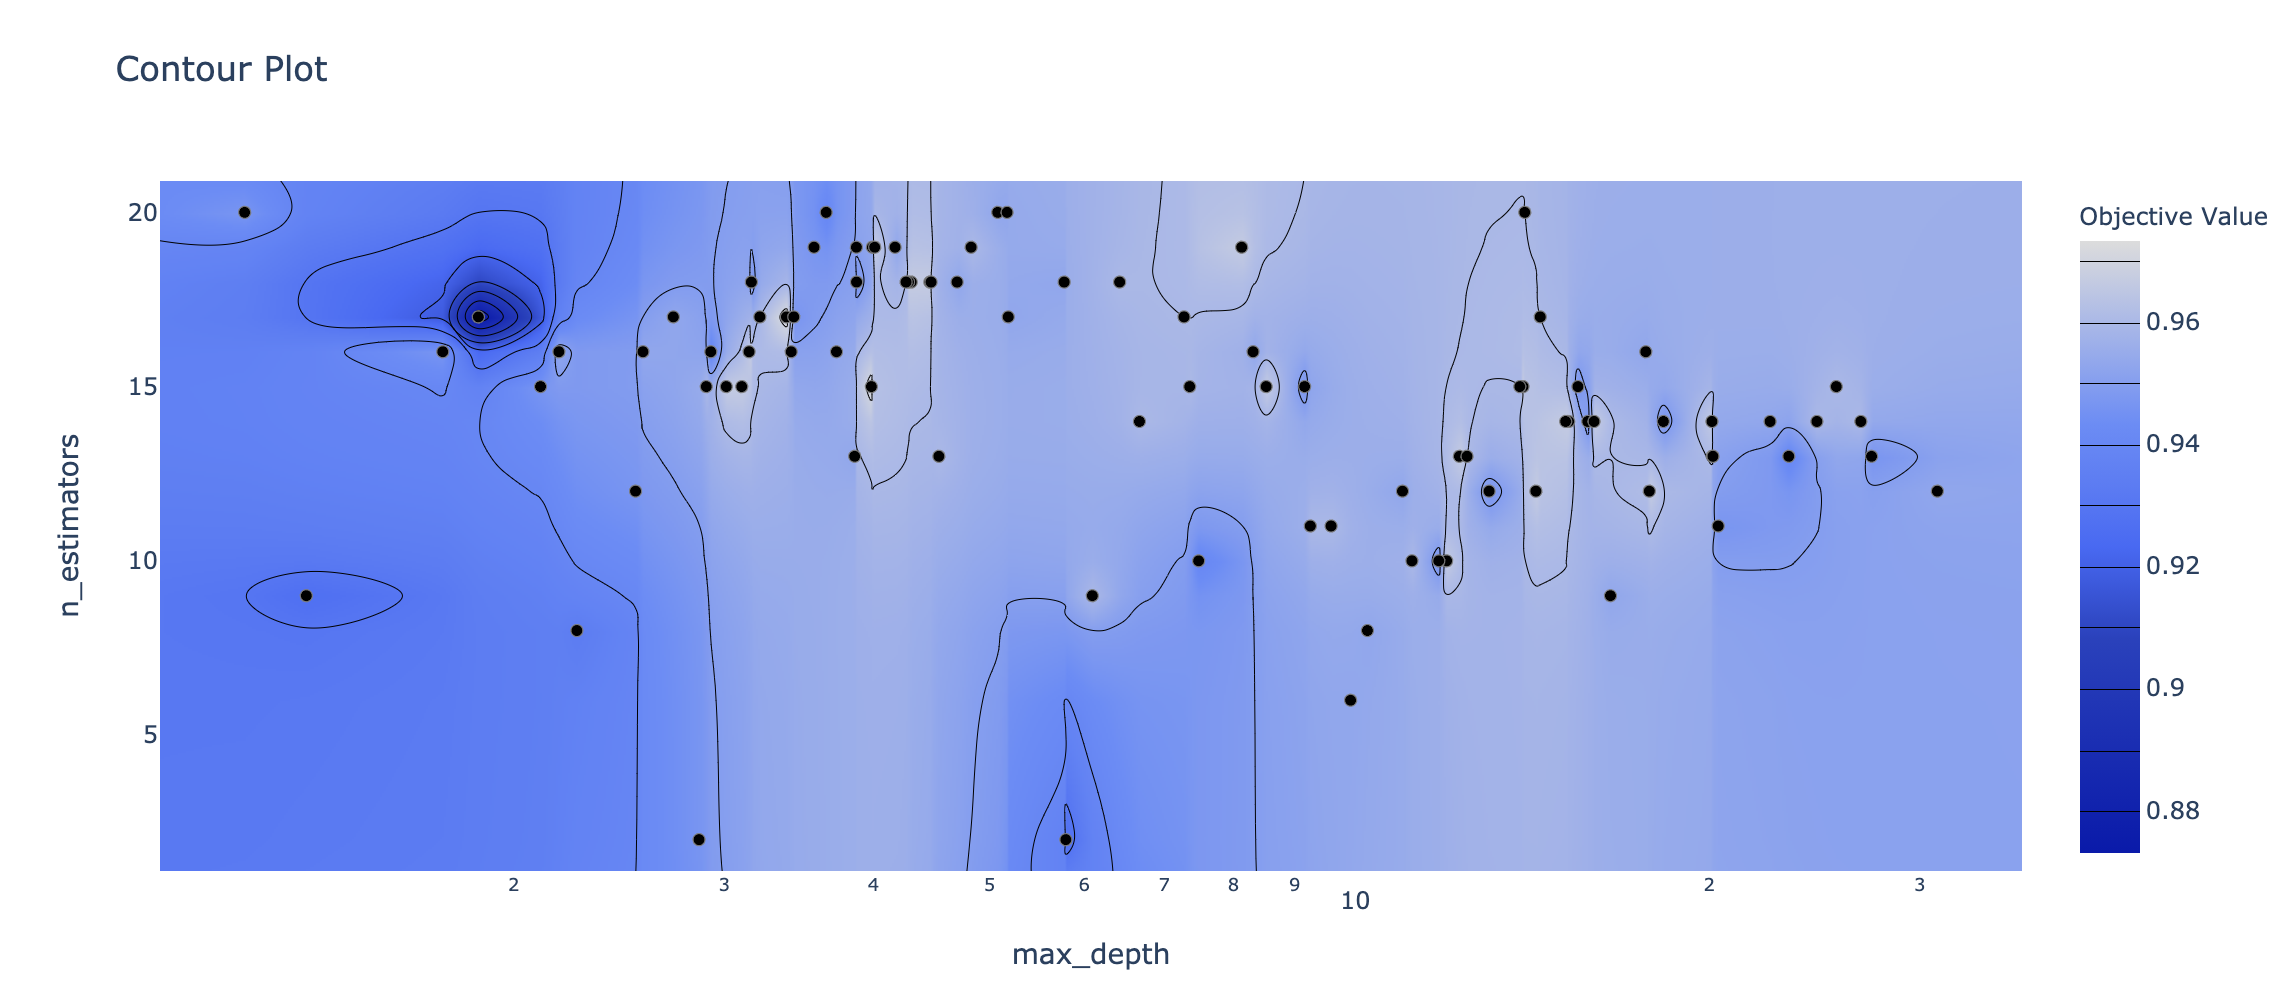

In [10]:
path="img1.png"
Image(path, width=800, height=400)